In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
plt.style.use('ggplot')

# Estimate H2S from RGB images (November 2018)

Using updated information provided by Pernilla - see e-mail received  26.11.2018 at 14.18 for details.

## 1. Data paths

In [2]:
# User input
# Calibration data folder
img_fold = (r'/home/jovyan/work/images/calibration_data')

# Calibration concs table
cal_xlsx = (r'/home/jovyan/work/images/calibration_data/calib_values.xlsx')

# Test image
test_img = (r'/home/jovyan/work/images/test_data/avlop_anlegg_ting.tif')

## 2. Read calibration data

In [3]:
# Read calib. data table
df = pd.read_excel(cal_xlsx)
df

,image_name,accum_micromol
0,im_a.tif,0.4130
1,im_b.tif,0.2030
2,im_c.tif,0.1050
3,im_d.tif,0.0511
4,im_e.tif,0.0259
5,im_f.tif,0.0126
6,im_g.tif,0.0063
7,im_h.tif,0.0035
8,im_i.tif,0.0014
9,im_j.tif,0.0007


## 3. Process images

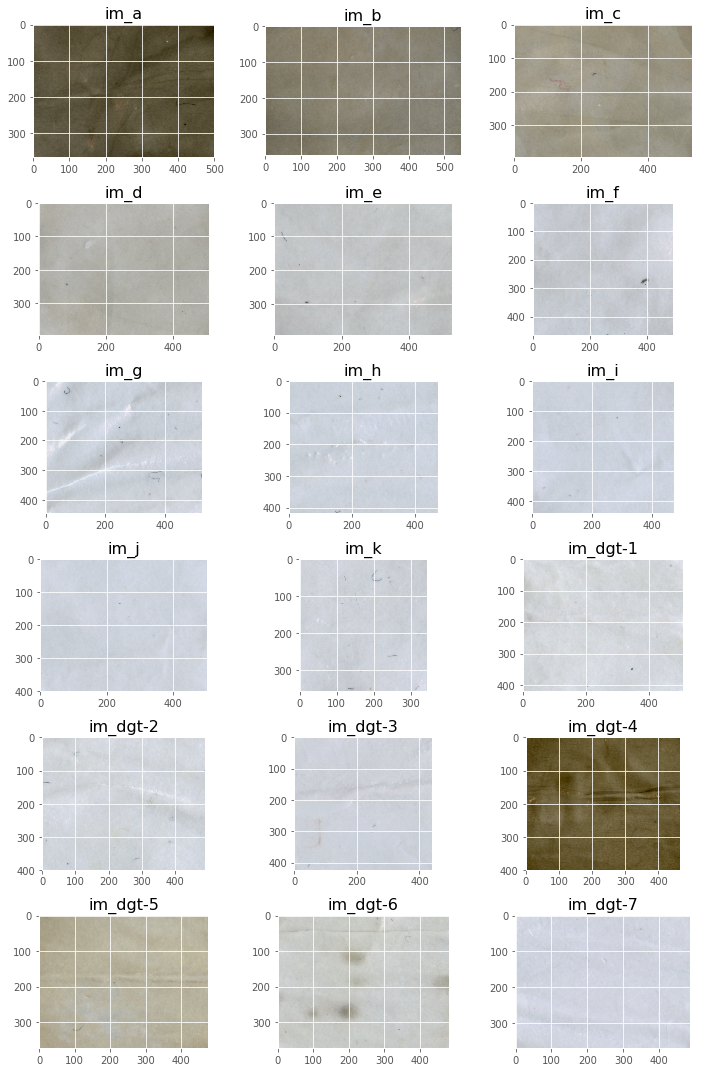

In [4]:
# Containers for image means
img_means = []

# Setup plot
fig, axes = plt.subplots(ncols=3, 
                         nrows=6, 
                         figsize=(10,15))
axes = axes.flatten()

# Loop over images
for idx, row in df.iterrows():
    # Read image
    img_path = os.path.join(img_fold, row['image_name'])
    img=mpimg.imread(img_path)
      
    # Plot
    img_plot = axes[idx].imshow(img)
    axes[idx].set_title(row['image_name'][:-4], fontsize=16)
    
    # Get means
    img_means.append(img.mean())

plt.tight_layout()

# Add results to df
df['mean_pixel_val'] = img_means

In [5]:
# Sort df
df.sort_values(['accum_micromol'], inplace=True)
df

,image_name,accum_micromol,mean_pixel_val
10,im_k.tif,0.0000,209.639719
9,im_j.tif,0.0007,211.445982
8,im_i.tif,0.0014,210.871018
12,im_dgt-2.tif,0.0030,213.014320
7,im_h.tif,0.0035,210.564062
6,im_g.tif,0.0063,208.312665
13,im_dgt-3.tif,0.0070,209.436893
11,im_dgt-1.tif,0.0070,214.458252
17,im_dgt-7.tif,0.0080,213.652154
5,im_f.tif,0.0126,202.272081


## 4. Plot calibration data (simple linear interpolation)

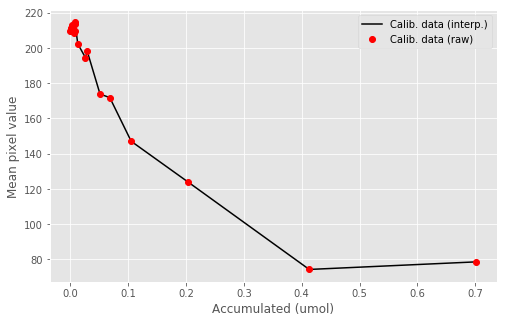

In [6]:
# Plot calibration data
fig = plt.figure(figsize=(8,5))
plt.plot(df['accum_micromol'], df['mean_pixel_val'], 'k-', label='Calib. data (interp.)')
plt.plot(df['accum_micromol'], df['mean_pixel_val'], 'ro', label='Calib. data (raw)')
plt.xlabel('Accumulated (umol)')
plt.ylabel('Mean pixel value')
plt.legend(loc='best')

The curve is poorly constrained at higher concentrations - more calibration data are needed in this region. At lower concentrations, results are fairly consistent.

## 5. Predict

The predicted accumulated value for the test image is 0.002 umol
The mean pixel value is 210.3


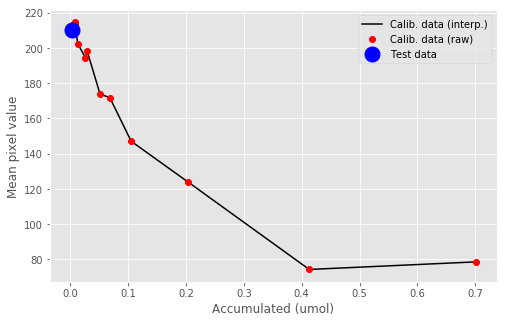

In [7]:
# Build linear interpolator
f = interpolate.interp1d(df['mean_pixel_val'].values,
                         df['accum_micromol'].values,
                         kind='linear')

# Read test image
img=mpimg.imread(test_img)

# Predict concentration
pred = f(img.mean())
print ('The predicted accumulated value for the test image is %.3f umol' % pred)
print ('The mean pixel value is %.1f' % img.mean())

# Plot
fig = plt.figure(figsize=(8,5))
plt.plot(df['accum_micromol'], df['mean_pixel_val'], 'k-', label='Calib. data (interp.)')
plt.plot(df['accum_micromol'], df['mean_pixel_val'], 'ro', label='Calib. data (raw)')
plt.plot(pred, img.mean(), 'bo', ms=15, label='Test data')
plt.xlabel('Accumulated (umol)')
plt.ylabel('Mean pixel value')
plt.legend(loc='best')

**The test image plots at roughly zero** i.e. it is indistinguishable from the blanks. The mean pixel value of 210 places it somewhere between calibration images $i$ and $j$.

## 6. Fit exponential

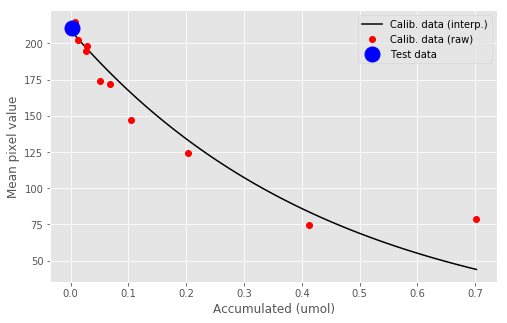

In [8]:
# Fit y = A*exp(b*x)
params, _ = curve_fit(lambda t,a,b: a*np.exp(b*t),  
                      df['accum_micromol'],  
                      df['mean_pixel_val'])

# Get y vals
x = np.linspace(df['accum_micromol'].min(),
                df['accum_micromol'].max(),
                100)
y = params[0]*np.exp(params[1]*x)

# Plot calibration data
fig = plt.figure(figsize=(8,5))
plt.plot(x, y, 'k-', label='Calib. data (interp.)')
plt.plot(df['accum_micromol'], df['mean_pixel_val'], 'ro', label='Calib. data (raw)')
plt.plot(pred, img.mean(), 'bo', ms=15, label='Test data')
plt.xlabel('Accumulated (umol)')
plt.ylabel('Mean pixel value')
plt.legend(loc='best')